## Imports

In [1]:
#!pip install -U dill==0.3.5.1
#!pip install -U tensorflow-io==0.27.0
#!pip install -U tensorflow-transform==1.11.0
#!pip install -U tensorflow==2.10.0
import tensorflow as tf
print(tf.__version__)

2.6.4


In [2]:
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings

In [3]:
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

plt.rc('font', size=16)

tfk = tf.keras
tfkl = tf.keras.layers

## Defines

### Seed

In [4]:
# Random seed for reproducibility
seed = 1337

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Constants

#### Imports

In [5]:
dataset_location = '/kaggle/input/training-dataset-homework2/'
x_name = 'x_train.npy'
y_name = 'y_train.npy'

#### Training

In [6]:
classes = 12
input_shape = (36, 6)

batch_size = 64
epochs = 200

label_mapping = {
    "Wish" : 0,
    "Another" : 1,
    "Comfortably" : 2,
    "Money" : 3,
    "Breathe" : 4,
    "Time" : 5,
    "Brain" : 6,
    "Echoes" : 7,
    "Wearing" : 8,
    "Sorrow" : 9,
    "Hey" : 10,
    "Shine" : 11
}

### Utility Functions

In [7]:
def build_sequences(df, window=200, stride=200):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for id in df['id'].unique():
        # Take only meaningful features
        temp = df[df['id'] == id][['x_axis','y_axis','z_axis']].values
        # Save the label
        label = df[df['id'] == id]['activity'].values[0]
        # Compute padding length
        padding_len = window - len(temp)%window
        # Create padding and concatenate it
        padding = np.zeros((padding_len,3), dtype='float64')
        temp = np.concatenate((temp,padding))
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [8]:
def inspect_multivariate(x, y, idx=None):
    if(idx == None):
        idx = np.random.randint(0, len(x))
    print(f"{y[idx]} --> {np.argmax(y[idx])}")
    df = pd.DataFrame(x[idx,:,:])
    df.plot(subplots=True, figsize=(17, 9))
    plt.show()

In [9]:
def evaluate_classes_performance(model, x_val, y_val):
    data_list = []
    label_list = []
    batch_index = 0

    data_array = np.array(x_val)
    label_array = np.array(y_val)   
    label_values = np.argmax(label_array, axis=1)
    predictions = model.predict(data_array)
    predictions_label = np.argmax(predictions, axis=1)
    
    report = classification_report(label_values, predictions_label)
    print(report)
    
    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:', accuracy.round(4))
    print('Precision:', precision.round(4))
    print('Recall:', recall.round(4))
    print('F1:', f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

In [10]:
def plot_history(history):
    best_epoch = np.argmax(history['val_accuracy'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Categorical Crossentropy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

## Load dataset

In [11]:
x_total = np.load(dataset_location + x_name)
y_total = np.load(dataset_location + y_name)

### Preprocessing

In [12]:
# Weight classes
class_weights = {}
_, label_counts = np.unique(y_total, return_counts=True)
class_mean = sum(label_counts) / len(label_counts)
for i, n in enumerate(label_counts):
    class_weights[i] = (1 / n) * class_mean
print(class_weights)

{0: 5.953431372549019, 1: 1.6456639566395665, 2: 0.7496913580246913, 3: 0.5312773403324584, 4: 3.264784946236559, 5: 1.3229847494553377, 6: 0.6466986155484558, 7: 2.9767156862745097, 8: 1.6868055555555554, 9: 0.2605105105105105, 10: 2.628787878787879, 11: 3.9689542483660127}


In [13]:
x_total /= np.max(np.abs(x_total), axis=0)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(
    x_total,
    y_total,
    test_size=0.2,
    random_state=seed
)

In [15]:
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] --> 9


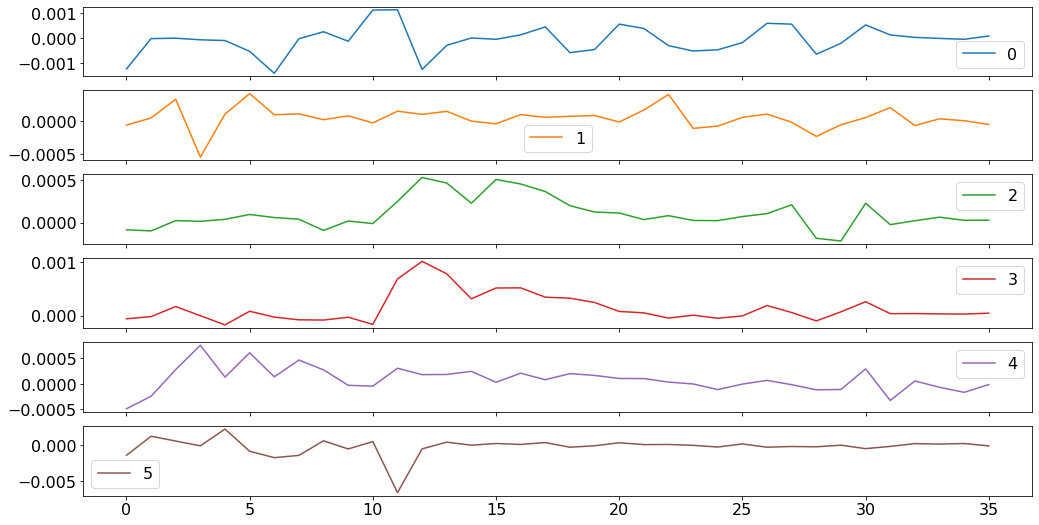

In [16]:
inspect_multivariate(x_train, y_train)

## Model

In [17]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(32, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(32)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [18]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [19]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # res = tfkl.Rescaling(scale=1./rescale_value)(input_layer)

    # Feature extractor
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [20]:
# model = build_LSTM_classifier(input_shape, classes)
# model = build_BiLSTM_classifier(input_shape, classes)
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

2022-12-11 14:33:11.522237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 14:33:11.611108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 14:33:11.611893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 14:33:11.613460: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 36, 128)           2432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 128)           49280     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512 

## Training

In [21]:
history = model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs,
    # class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


2022-12-11 14:33:14.367703: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-11 14:33:15.910870: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


31/31 [==============================] - 8s 11ms/step - loss: 2.3062 - accuracy: 0.3155 - val_loss: 2.2217 - val_accuracy: 0.2963
Epoch 2/200
31/31 [==============================] - 0s 4ms/step - loss: 2.0672 - accuracy: 0.3345 - val_loss: 2.0690 - val_accuracy: 0.3189
Epoch 3/200
31/31 [==============================] - 0s 4ms/step - loss: 1.9844 - accuracy: 0.3505 - val_loss: 2.0319 - val_accuracy: 0.3230
Epoch 4/200
31/31 [==============================] - 0s 4ms/step - loss: 1.9450 - accuracy: 0.3603 - val_loss: 1.9959 - val_accuracy: 0.3313
Epoch 5/200
31/31 [==============================] - 0s 4ms/step - loss: 1.9286 - accuracy: 0.3690 - val_loss: 1.9809 - val_accuracy: 0.3333
Epoch 6/200
31/31 [==============================] - 0s 4ms/step - loss: 1.9062 - accuracy: 0.3762 - val_loss: 1.9865 - val_accuracy: 0.3313
Epoch 7/200
31/31 [==============================] - 0s 4ms/step - loss: 1.9050 - accuracy: 0.3767 - val_loss: 1.9649 - val_accuracy: 0.3354
Epoch 8/200
31/31 [=====

## Visualize Results

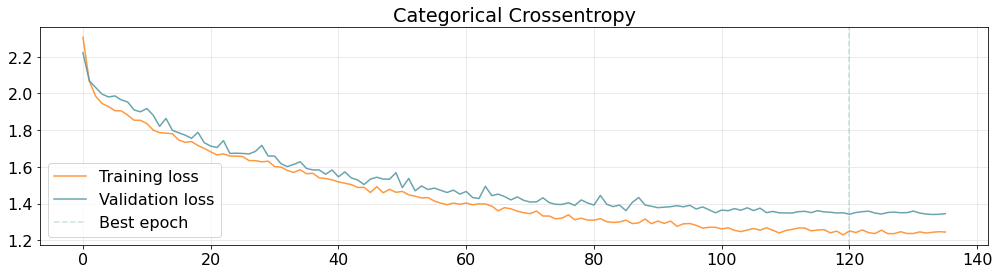

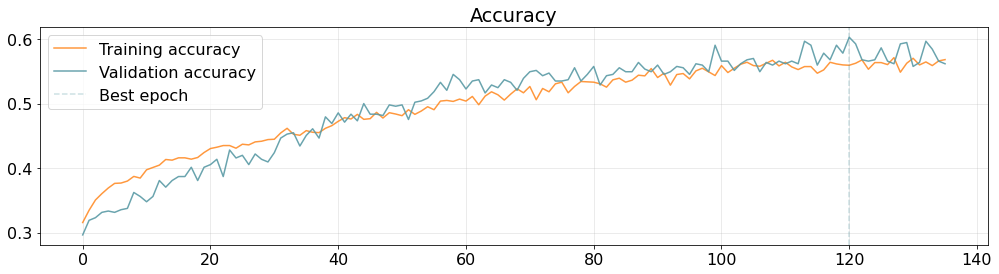

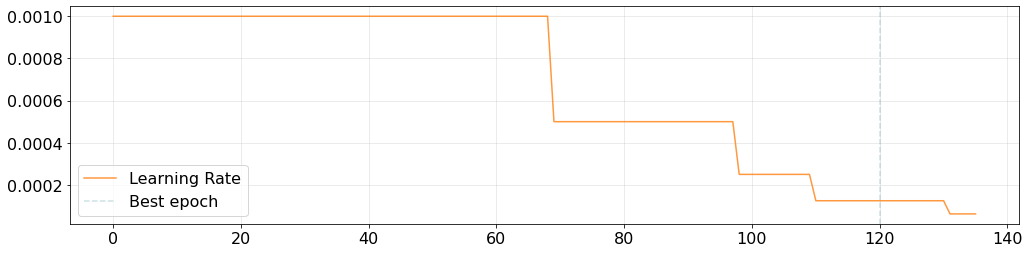

In [22]:
plot_history(history)

              precision    recall  f1-score   support

           0       0.50      0.11      0.18         9
           1       0.64      0.62      0.63        34
           2       0.80      0.72      0.76        54
           3       0.38      0.21      0.27        73
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        32
           6       0.62      0.86      0.72        56
           7       0.00      0.00      0.00        12
           8       0.97      0.76      0.85        38
           9       0.53      0.88      0.66       144
          10       0.86      0.75      0.80        16
          11       1.00      0.12      0.22         8

    accuracy                           0.60       486
   macro avg       0.52      0.42      0.42       486
weighted avg       0.55      0.60      0.55       486

Accuracy: 0.6029
Precision: 0.5243
Recall: 0.4195
F1: 0.4242


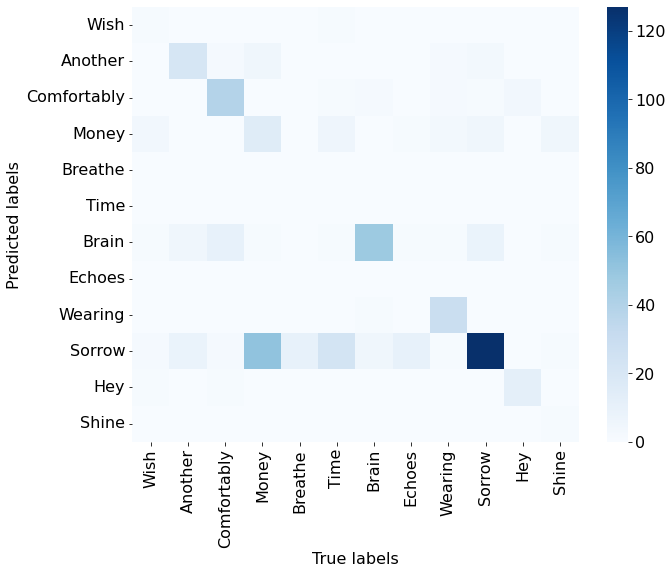

In [23]:
evaluate_classes_performance(model, x_val, y_val)

## Save

In [24]:
import shutil
model.save('ANN_Homework2_Model')
shutil.make_archive("ANN_Homework2_Model", 'zip', '/kaggle/working/ANN_Homework2_Model')

2022-12-11 14:33:43.240251: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


'/kaggle/working/ANN_Homework2_Model.zip'